https://pyscience.wordpress.com/2014/10/19/image-segmentation-with-python-and-simpleitk/
https://github.com/dave3d/dicom2stl

In [1]:
import SimpleITK

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
def sitk_load_dicom(path):
    reader = SimpleITK.ImageSeriesReader()
    filenames = reader.GetGDCMSeriesFileNames(path)
    reader.SetFileNames(filenames)
    return reader.Execute()

In [11]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    spacing = img.GetSpacing()
  
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi

    extent = (0, nda.shape[1] * spacing[1], nda.shape[0] * spacing[0], 0)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda, extent=extent, interpolation=None)

    if title:
        plt.title(title)

    plt.show()

# Loading

In [5]:
pathDICOM = '../../DICOM/MyHead/'
idxSlice = 50

In [6]:
serie = SimpleITK_load_dicom(pathDICOM)
image = serie[:,:,idxSlice]

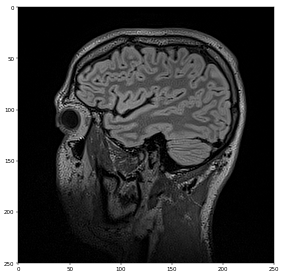

In [12]:
sitk_show(image)

# Smoothing / Denoising

In [8]:
imageSmooth = SimpleITK.CurvatureFlow(image1=image, timeStep=0.125, numberOfIterations=5)

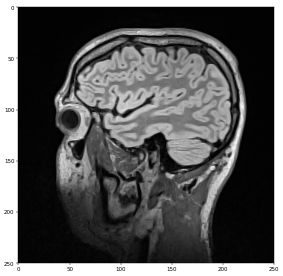

In [13]:
sitk_show(imageSmooth)

# SEGMENTATION OF THE WHITE-MATTER

In [24]:
labelWhiteMatter = 1
whiteSeeds = [(150, 75)]

In [25]:
imageWhiteMatter = SimpleITK.ConnectedThreshold(image1=imageSmooth,
                                         seedList=whiteSeeds,
                                         lower=130,
                                         upper=190,
                                         replaceValue=labelWhiteMatter)

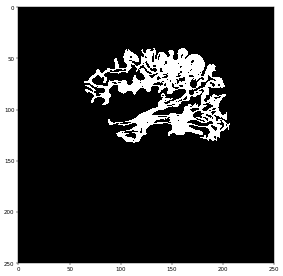

In [18]:
sitk_show(imageWhiteMatter)

In [19]:
# Rescale 'imageSmooth' and cast it to an integer type to match that of 'imageWhiteMatter'
imageSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imageSmooth), imageWhiteMatter.GetPixelID())

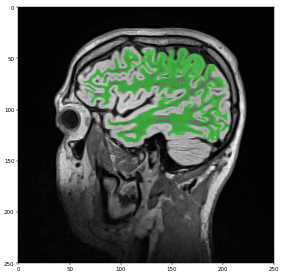

In [20]:
# Use 'LabelOverlay' to overlay 'imageSmooth' and 'imageWhiteMatter'
sitk_show(SimpleITK.LabelOverlay(imageSmoothInt, imageWhiteMatter))

# Hole filling

In [22]:
imageWhiteMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imageWhiteMatter,
                                                           radius=[2]*3,
                                                           majorityThreshold=1,
                                                           backgroundValue=0,
                                                           foregroundValue=labelWhiteMatter)

sitk_show(SimpleITK.LabelOverlay(imageSmoothInt, imageWhiteMatterNoHoles))

# SEGMENTATION OF THE GRAY-MATTER

In [26]:
labelGrayMatter = 2
graySeeds = [(119, 83), (198, 80), (185, 102), (164, 43)]

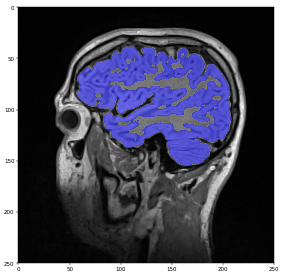

In [27]:
imageGrayMatter = SimpleITK.ConnectedThreshold(image1=imageSmooth,
                                         seedList=graySeeds,
                                         lower=150,
                                         upper=270,
                                         replaceValue=labelGrayMatter)

imageGrayMatterNoHoles = SimpleITK.VotingBinaryHoleFilling(image1=imageGrayMatter,
                                                           radius=[2]*3,
                                                           majorityThreshold=1,
                                                           backgroundValue=0,
                                                           foregroundValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imageSmoothInt, imageGrayMatterNoHoles))

# Combination

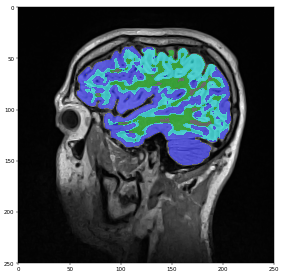

In [29]:
imageLabels = imageWhiteMatterNoHoles | imageGrayMatterNoHoles

sitk_show(SimpleITK.LabelOverlay(imageSmoothInt, imageLabels))

# Masking

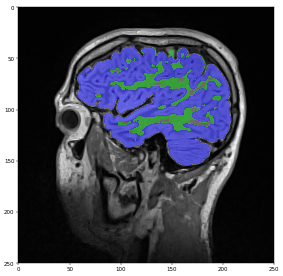

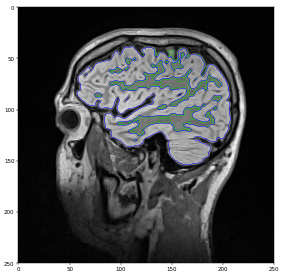

In [67]:
imageMask = (imageWhiteMatterNoHoles / labelWhiteMatter) * (imageGrayMatterNoHoles / labelGrayMatter)
imageMask = SimpleITK.Cast(imageMask, imageWhiteMatter.GetPixelID())
imageWhiteMatterNoHoles -= imageMask * labelWhiteMatter
imageLabels = imageWhiteMatterNoHoles + imageGrayMatterNoHoles

sitk_show(SimpleITK.LabelOverlay(imageSmoothInt, imageLabels))

sitk_show(SimpleITK.LabelOverlay(imageSmoothInt, SimpleITK.LabelContour(imageLabels)))